In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
from IPython.display import HTML
from matplotlib import cm

# compose the NN model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Mostra/Nascondi celle</a>.''')

# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
# Valentina Guarino, mat. 978477

## <span style="color:red">  ESERCITAZIONE 11</span>

Scopo dell'esercitazione è allenare una rete neurale a risolvere un problema di predizione del tipo 
$$ y_i= f(x_i) + \eta_i$$

Dato un set di variabili indipendenti $\{x_i\}_{i=1}^N$ e un rumore gaussiano ad esse associato $\eta_i$, scopo della rete è trovare il set di variabili dipendenti $\{y_i\}_{i=1}^N$, legate alle $x_i$ tramite la funzione delle *true features* (eventualmente incognita) $f(x_i)$. 

L'errore gaussiano è un errore scorrelato, tale che 

$$
\langle \eta_i \rangle=0 \\
\langle \eta_i \eta_j \rangle = \delta_{ij} \sigma
$$

Per fare una corretta predizione bisognerà imparare i parametri da cui dipenderà la rete neurale: questi sono i *pesi* e i *bias*. I dati $\{x_i\}_{i=1}^N$ verranno divisi in due set: un **training set**, più popoloso, utilizzato per allenare la rete e trovare i valori di pesi e bias tramite il fit dei suoi dati; un **validation set**, contenente punti mai utilizzati dal modello su cui vengono svolte predizioni per valutare l'accuratezza del modello utilizzato. 

Per valutare la performance di accuratezza del modello si possono utilizzare diverse loss function, quale ad esempio la **mean squared error** sul validation set (o sul training set):

$$L(x) =  \frac{1}{N_\mathrm{test}}\sum_{j=1}^{N_\mathrm{test}} (y_j^\mathrm{pred}-y_j)^2$$

Essa compara le variabili $\{y_i^{pred}\}_{i=1}^N$ predette dal modello con i valori veri che dovrebbero assumere $\{y_i\}_{i=1}^N$. Poiché in questo frangente si stanno utilizzando metodi di *supervised learning*, i dati che abbiamo sono labeled data: si conoscono i valori delle label $\{y_i\}_{i=1}^N$ associate alle $\{x_i\}_{i=1}^N$, e scopo dell'allenamento è trovare pesi e bias associati alla funzione $f(x_i)$ di modo da riuscire a predirre le label anche per nuovi set di dati con label incognite.

Per minimizzare la loss, e dunque aumentare l'accuratezza, si possono usare degli ottimizzatori quale lo **stochastic gradient descent**, che cerca il minimo della funzione $L(x)$ tramite discesa stocastica del gradiente.

### Esercizio 11.01

Scopo dell'esercitazione è valutare come vari la regressione lineare della funzione

$$f(x) = 2x + 1$$

al variare degli **iperparametri** del modello:
- $N_{epoch} \in [30, 50, 100, 250, 500]$ : numero di epoche su cui viene allenata la rete
- $N_{train} \in [100, 250, 500, 10^3, 10^4]$: numero di valori del training set
- $\sigma \in [0.0, 0.01, 0.1, 0.5, 1.0]$: errore gaussiano aggiunto al modello 

Si utilizzerà un training set contenente $N_{train}$ coppie $(x, y)$ per trovare i pesi e i bias: nel nostro caso si avrà un solo peso pari al coefficiente angolare della funzione $w_1 = m$ e un bias $b$ pari alla sua intercetta.
Successivamente verrà usato il validation set contenente $N_{valid}$ coppie $(x, y)$ per valutare l'efficacia di predizione del modello: in particolare, conoscendo la funzione $f(x)$ generante le true features, si potrà confrontare il risultato della predizione effettuata sul validation set con la funzione target 

$$y_{target} = 2x_{valid} + 1$$

Si utilizzerà come rete neurale un solo layer a singolo neurone; l'intero training set viene diviso in *minibatch* di ampiezza fissata, che verrà scelta in base al variare del numero di dati $N_{train}$.

#### Variazione $N_{epoch}$

Iniziamo ad allenare la rete tenendo fissati $N_{train}$ e $\sigma$, e valutando quanto varia la loss e la metrica del modello al variare delle epoche. La metrica è una funzione utilizzata per valutare la performance del modello: essa non viene utilizzata durante la fase di training, ma soltanto durante la fase di validazione. Nel nostro caso utilizzeremo come metrica la stessa funzione utilizzata come loss function, ovvero la mean squared error.

Fissiamo il set di training $N_{train} = 100$, il set di validazione $N_{valid} = 10$ e l'errore $\sigma = 0.0$. I minibatch utilizzati hanno, in questo caso, ampiezza $batchsize = 32$

In [4]:
# target parameters of f(x) = m*x + b
m = 2 # slope
b = 1 # intersect

In [3]:
#Genero i dati di training e di validation tra (-1, 1)
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 100)
x_valid = np.random.uniform(-1, 1, 10) #Valori di input del test set
x_valid.sort()

y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.0 # noise standard deviation

y_train = np.random.normal(m * x_train + b, sigma) #Label del training set
y_valid = np.random.normal(m * x_valid + b, sigma) #Label del test set

In [4]:
model = tf.keras.Sequential(name='Sequential_model') 
model.add(Dense(1, input_shape=(1,)))  
model.compile(optimizer='sgd', loss='mse', metrics=['mse']) 
model.summary()

Model: "Sequential_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Utilizzando diverse epoche, valutiamo la loss e la metrica al variare delle stesse. Valutiamo inoltre i valori dei parametri $m, b$ trovati, confrontandoli con i parametri target $m = 2$ e $b = 1$.

#### <span style="color:red">  30 epoche </span>

In [5]:
# fit the model using training dataset
# over 30 epochs of 32 batch size each
# report training progress against validation data
history_30 = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=30,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [6]:
# return weights and biases
weights_30 = model.get_weights()
print("Valori dei pesi dopo 30 epoche: \n")

print("m = ", weights_30[0][0][0])
print("b = ", weights_30[1][0])

Valori dei pesi dopo 30 epoche: 

m =  1.1943282
b =  0.8572082


Possiamo visualizzare l'andamento della curva $\hat{f}(x) = w_1x + b = mx + b$ predetta dalla rete rispetto alla funzione reale $f(x) = 2x + 1$

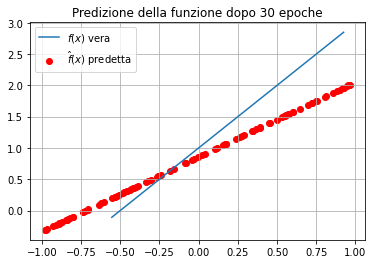

In [7]:
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r', label = "$\hat{f}(x)$ predetta")
plt.plot(x_valid, y_target, label = "$f(x)$ vera")
plt.title("Predizione della funzione dopo 30 epoche")
plt.legend(loc="best")
plt.grid(True)
plt.show()

Poiché i pesi predetti dalla rete sul training set sono molto diversi da quelli veri, il modello di regressione lineare non è accurato e la curva predetta $\hat{f}(x)$ non segue la curva reale $f(x)$. 

Si può anche valutare l'andamento della loss e dell'accuracy sia per il validation set sia rispetto alla curva esatta:

In [8]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=32, verbose=0)
loss_30 = score[0] 
acc_30 = score[1]
# print performance
print("Validation set: \n")
print('Test loss dopo 30 epoche:', score[0])
print('Test accuracy dopo 30 epoche:', score[1])

Validation set: 

Test loss dopo 30 epoche: 0.24402864277362823
Test accuracy dopo 30 epoche: 0.24402864277362823


In [9]:
# evaluate model with the exact curve
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=0)

# print performance
print("Valutazione rispetto alla curva esatta: \n")
print('Test loss dopo 30 epoche:', score[0])
print('Test accuracy dopo 30 epoche:', score[1])

Valutazione rispetto alla curva esatta: 

Test loss dopo 30 epoche: 0.24402864277362823
Test accuracy dopo 30 epoche: 0.24402864277362823


Infine possiamo plottare l'andamento della loss function per i dati del training set e i dati del validation set

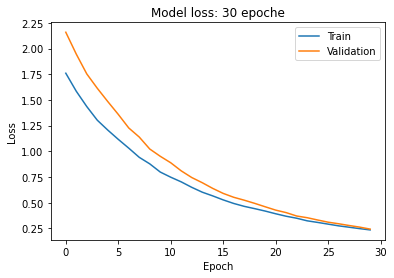

In [10]:
# look into training history
# Plot training & validation loss values
plt.plot(history_30.history['loss'])
plt.plot(history_30.history['val_loss'])
plt.title('Model loss: 30 epoche')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

Vediamo come sia i valori della loss function che quelli dell'accuracy non siano sufficientemente minimimizzati; un modello con **$N_{train}$ = 100** e **$N_{epoch}$ = 30** non è dunque un buon modello per il nostro problema di regressione lineare.

#### <span style="color:red">  50 epoche </span>

In [11]:
# fit the model using training dataset
# over 50 epochs of 32 batch size each
# report training progress against validation data
history_50 = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=50,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [12]:
# return weights and biases
weights_50 = model.get_weights()
print("Valori dei pesi al variare delle epoche \n")

print("50 epoche:")
print("m = ", weights_50[0][0][0])
print("b = ", weights_50[1][0])

Valori dei pesi al variare delle epoche 

50 epoche:
m =  1.7870651
b =  0.9845877


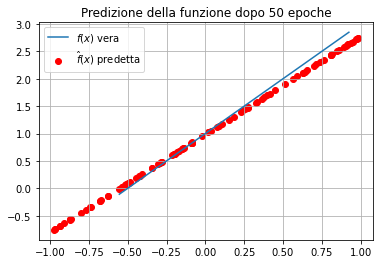

In [13]:
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r', label = "$\hat{f}(x)$ predetta")
plt.plot(x_valid, y_target, label = "$f(x)$ vera")
plt.title("Predizione della funzione dopo 50 epoche")
plt.legend(loc="best")
plt.grid(True)
plt.show()

Aumentando il numero di epoche a $50$ il nostro modello allenatosi con un numero di dati $N_{train} = 100$ riesce a predirre in modo migliore la forma della $\hat{f}(x)$. La curva predetta dal modello su $100$ nuovi punti distribuiti in modo random tra $[-1, 1]$, difatti, pur non seguendo ancora l'andamento della curva reale $f(x)$, inizia ad avvicinarsi ad essa. Ciò avviene in quanto l'intero training set $N_{train} = 100$ viene utilizzato dalla rete neurale per $50$ volte, e pertanto i valori dei pesi $w_1 = m$ e $b$ iniziano ad avere un accordo maggiore con i parametri reali.

Possiamo nuovamente valutare la loss e l'accuracy del modello e plottare l'andamento della prima per il training set e il validation set:

In [14]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=32, verbose=0)
loss_50 = score[0] 
acc_50 = score[1]
# print performance
print("Validation set: \n")
print('Test loss dopo 50 epoche:', score[0])
print('Test accuracy dopo 50 epoche:', score[1])

Validation set: 

Test loss dopo 50 epoche: 0.014318300411105156
Test accuracy dopo 50 epoche: 0.014318300411105156


In [15]:
# evaluate model with the exact curve
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=0)

# print performance
print("Valutazione rispetto alla curva esatta: \n")
print('Test loss dopo 50 epoche:', score[0])
print('Test accuracy dopo 50 epoche:', score[1])

Valutazione rispetto alla curva esatta: 

Test loss dopo 50 epoche: 0.014318300411105156
Test accuracy dopo 50 epoche: 0.014318300411105156


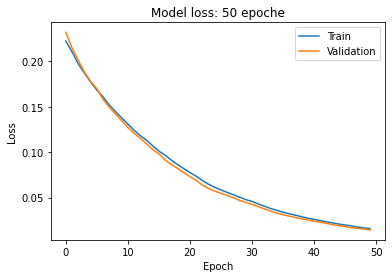

In [16]:
# look into training history
# Plot training & validation loss values
plt.plot(history_50.history['loss'])
plt.plot(history_50.history['val_loss'])
plt.title('Model loss: 50 epoche')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

Si può notare come i valori delle loss function siano passati da :

In [17]:
print("L(x) = ", loss_30)

L(x) =  0.24402864277362823


 nel caso di $30$ epoche ad un valore

In [18]:
print("L(x) = ", loss_50)

L(x) =  0.014318300411105156


nel caso di $50$ epoche.

Si può provare ad aumentare ulteriormente il numero di epoche, per cercare una maggiore accuratezza del modello. 

Valutiamo ora soltanto i valori dei pesi trovati nelle successive epoche, per scegliere il numero di epoche che porta ad un risultato maggiormente accurato.

#### <span style="color:red">  100 epoche </span>

In [19]:
# fit the model using training dataset
# over 100 epochs of 32 batch size each
# report training progress against validation data
history_100 = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=100,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [20]:
# return weights and biases
weights_100 = model.get_weights()
print("Valori dei pesi dopo 100 epoche: \n")

print("m = ", weights_100[0][0][0])
print("b = ", weights_100[1][0])

Valori dei pesi dopo 100 epoche: 

m =  1.9852539
b =  0.9992128


#### <span style="color:red">  250 epoche </span>

In [21]:
# fit the model using training dataset
# over 250 epochs of 32 batch size each
# report training progress against validation data
history_250 = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=250,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [22]:
# return weights and biases
weights_250 = model.get_weights()
print("Valori dei pesi dopo 250 epoche: \n")

print("m = ", weights_250[0][0][0])
print("b = ", weights_250[1][0])

Valori dei pesi dopo 250 epoche: 

m =  1.9999815
b =  0.9999987


#### <span style="color:red">  500 epoche </span>

In [23]:
# fit the model using training dataset
# over 500 epochs of 32 batch size each
# report training progress against validation data
history_500 = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [24]:
# return weights and biases
weights_500 = model.get_weights()
print("Valori dei pesi dopo 500 epoche: \n")

print("m = ", weights_500[0][0][0])
print("b = ", weights_500[1][0])

Valori dei pesi dopo 500 epoche: 

m =  1.9999956
b =  0.9999998


Dopo $N_{epoch} = 500$ si trovano i valori dei pesi più accurati; si può valutare l'andamento della curva predetta $\hat{f}(x)$ e i valori di loss e accuracy nel suddetto caso

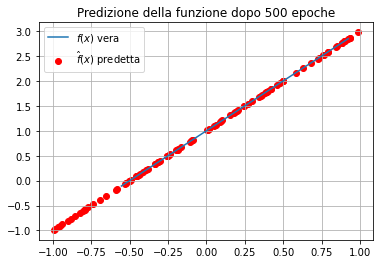

In [25]:
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r', label = "$\hat{f}(x)$ predetta")
plt.plot(x_valid, y_target, label = "$f(x)$ vera")
plt.title("Predizione della funzione dopo 500 epoche")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [26]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=32, verbose=0)
loss_500 = score[0] 
acc_500 = score[1]
# print performance
print("Validation set: \n")
print('Test loss dopo 500 epoche:', score[0])
print('Test accuracy dopo 500 epoche:', score[1])

Validation set: 

Test loss dopo 500 epoche: 5.977940364942924e-12
Test accuracy dopo 500 epoche: 5.977940364942924e-12


In [27]:
# evaluate model with the exact curve
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=0)

# print performance
print("Valutazione rispetto alla curva esatta: \n")
print('Test loss dopo 500 epoche:', score[0])
print('Test accuracy dopo 500 epoche:', score[1])

Valutazione rispetto alla curva esatta: 

Test loss dopo 500 epoche: 5.977940364942924e-12
Test accuracy dopo 500 epoche: 5.977940364942924e-12


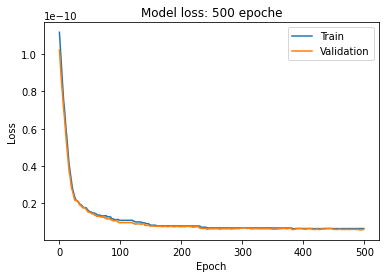

In [28]:
# look into training history
# Plot training & validation loss values
plt.plot(history_500.history['loss'])
plt.plot(history_500.history['val_loss'])
plt.title('Model loss: 500 epoche')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

La loss function, con $N_{epoch} = 500$, viene minimizzata con uno stochastic gradient descent fino a un valore:

In [29]:
print("L(x) = ", loss_500)

L(x) =  5.977940364942924e-12


Poiché essa, definita come una mean squared error, mi dà la differenza quadratica media tra le variabili predette e le label vere, abbiamo trovato in questo caso un accordo molto preciso tra le predizioni e i dati veri.

Utilizzando dunque un numero di epoche $N_{epoch} = 500$, possiamo ora provare ad ampliare il set di training e di validation per valutare eventuali miglioramenti nell'accuratezza del modello. 

Vengono nuovamente valutati soltanto i valori dei pesi $w_1 = m$ e $b$; sul valore di $N_{train}$ che porta a miglior convergenza dei pesi con i valori veri verranno effettuate analisi ulteriori, valutando anche andamento della curva predetta $\hat{f}(x)$ e andamento di loss ed accuracy.

#### Variazione $N_{train}$

Fissiamo le epoche $N_{epoch} = 500$ e l'errore $\sigma = 0.0$. I minibatch utilizzati hanno, in questo caso, ampiezza variabile in base al numero di dati utilizzati:
- $batchsize = 32$  per $N_{train} = 100$
- $batchsize = 50$  per $N_{train} = 250$
- $batchsize = 100$ per $N_{train} = 500$
- $batchsize = 250$ per $N_{train} = 10^3$
- $batchsize = 500$ per $N_{train} = 10^4$


In [30]:
model = tf.keras.Sequential(name='Sequential_model') 
model.add(Dense(1, input_shape=(1,)))  
model.compile(optimizer='sgd', loss='mse', metrics=['mse']) 

#### <span style="color:blue">  $N_{train} = 100, N_{valid} = 10$ </span>

In [31]:
#Genero i dati di training e di validation tra (-1, 1)
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 100)
x_valid = np.random.uniform(-1, 1, 10) #Valori di input del test set
x_valid.sort()

y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.0 # noise standard deviation

y_train = np.random.normal(m * x_train + b, sigma) #Label del training set
y_valid = np.random.normal(m * x_valid + b, sigma) #Label del test set

In [32]:
# fit the model using training dataset
# over 500 epochs of 32 batch size each
# report training progress against validation data
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [33]:
# return weights and biases
weights = model.get_weights()
print("Valori dei pesi per N_train = 100: \n")

print("m = ", weights[0][0][0])
print("b = ", weights[1][0])

Valori dei pesi per N_train = 100: 

m =  1.9999945
b =  0.9999997


In [34]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=32, verbose=0)
loss_1 = score[0] 
acc_1 = score[1]

#### <span style="color:blue">  $N_{train} = 250, N_{valid} = 25$ </span>

In [35]:
#Genero i dati di training e di validation tra (-1, 1)
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 250)
x_valid = np.random.uniform(-1, 1, 25) #Valori di input del test set
x_valid.sort()

y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.0 # noise standard deviation

y_train = np.random.normal(m * x_train + b, sigma) #Label del training set
y_valid = np.random.normal(m * x_valid + b, sigma) #Label del test set

In [36]:
# fit the model using training dataset
# over 500 epochs of 32 batch size each
# report training progress against validation data
history_2 = model.fit(x=x_train, y=y_train, 
          batch_size=50, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [37]:
# return weights and biases
weights_2 = model.get_weights()
print("Valori dei pesi per N_train = 250: \n")

print("m = ", weights_2[0][0][0])
print("b = ", weights_2[1][0])

Valori dei pesi per N_train = 250: 

m =  1.9999945
b =  0.99999976


In [38]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=50, verbose=0)
loss_2 = score[0] 
acc_2 = score[1]

#### <span style="color:blue">  $N_{train} = 500, N_{valid} = 50$ </span>

In [39]:
#Genero i dati di training e di validation tra (-1, 1)
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 500)
x_valid = np.random.uniform(-1, 1, 50) #Valori di input del test set
x_valid.sort()

y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.0 # noise standard deviation

y_train = np.random.normal(m * x_train + b, sigma) #Label del training set
y_valid = np.random.normal(m * x_valid + b, sigma) #Label del test set

In [40]:
# fit the model using training dataset
# over 500 epochs of 32 batch size each
# report training progress against validation data
history_3 = model.fit(x=x_train, y=y_train, 
          batch_size=100, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [43]:
# return weights and biases
weights_3 = model.get_weights()
print("Valori dei pesi per N_train = 500: \n")

print("m = ", weights_3[0][0][0])
print("b = ", weights_3[1][0])

Valori dei pesi per N_train = 500: 

m =  1.9999945
b =  0.99999976


In [44]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=100, verbose=0)
loss_3 = score[0] 
acc_3 = score[1]

#### <span style="color:blue">  $N_{train} = 10^3, N_{valid} = 100$ </span>

In [45]:
#Genero i dati di training e di validation tra (-1, 1)
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 1000)
x_valid = np.random.uniform(-1, 1, 100) #Valori di input del test set
x_valid.sort()

y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.0 # noise standard deviation

y_train = np.random.normal(m * x_train + b, sigma) #Label del training set
y_valid = np.random.normal(m * x_valid + b, sigma) #Label del test set

In [46]:
# fit the model using training dataset
# over 500 epochs of 32 batch size each
# report training progress against validation data
history_4 = model.fit(x=x_train, y=y_train, 
          batch_size=250, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [48]:
# return weights and biases
weights_4 = model.get_weights()
print("Valori dei pesi per N_train = 1000: \n")

print("m = ", weights_4[0][0][0])
print("b = ", weights_4[1][0])

Valori dei pesi per N_train = 1000: 

m =  1.9999945
b =  0.99999976


In [49]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=250, verbose=0)
loss_4 = score[0] 
acc_4 = score[1]

#### <span style="color:blue">  $N_{train} = 10^4, N_{valid} = 10^3$ </span>

In [50]:
#Genero i dati di training e di validation tra (-1, 1)
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 10000)
x_valid = np.random.uniform(-1, 1, 1000) #Valori di input del test set
x_valid.sort()

y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.0 # noise standard deviation

y_train = np.random.normal(m * x_train + b, sigma) #Label del training set
y_valid = np.random.normal(m * x_valid + b, sigma) #Label del test set

In [51]:
# fit the model using training dataset
# over 500 epochs of 32 batch size each
# report training progress against validation data
history_5 = model.fit(x=x_train, y=y_train, 
          batch_size=500, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [52]:
# return weights and biases
weights_5 = model.get_weights()
print("Valori dei pesi per N_train = 10000: \n")

print("m = ", weights_5[0][0][0])
print("b = ", weights_5[1][0])

Valori dei pesi per N_train = 10000: 

m =  1.9999945
b =  0.99999976


In [53]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=500, verbose=0)
loss_5 = score[0] 
acc_5 = score[1]

Possiamo notare come, oltre un numero $N_{train} = 250$, l'aumento del set di training non porti ad ulteriori miglioramenti nel calcolo di pesi e bias. Possiamo allora scegliere **$N_{train}$ = 250** come ampiezza del set di training, e valutare l'andamento della curva predetta $\hat{f}(x)$ e della loss function per esso.

In [59]:
#Genero i dati di training e di validation tra (-1, 1)
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 250)
x_valid = np.random.uniform(-1, 1, 25) #Valori di input del test set
x_valid.sort()

y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.0 # noise standard deviation

y_train = np.random.normal(m * x_train + b, sigma) #Label del training set
y_valid = np.random.normal(m * x_valid + b, sigma) #Label del test set

In [60]:
# fit the model using training dataset
# over 500 epochs of 32 batch size each
# report training progress against validation data
history_final = model.fit(x=x_train, y=y_train, 
          batch_size=50, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

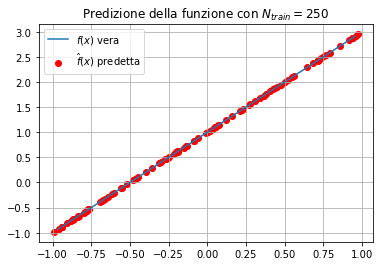

In [61]:
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r', label = "$\hat{f}(x)$ predetta")
plt.plot(x_valid, y_target, label = "$f(x)$ vera")
plt.title("Predizione della funzione con $N_{train} = 250$")
plt.legend(loc="best")
plt.grid(True)
plt.show()

I valori di loss e accuracy:

In [62]:
print('Test loss per N_train = 250:', loss_2)
print('Test accuracy per N_train = 250:', acc_2)

Test loss per N_train = 250: 1.2878680760719519e-11
Test accuracy per N_train = 250: 1.2878680760719519e-11


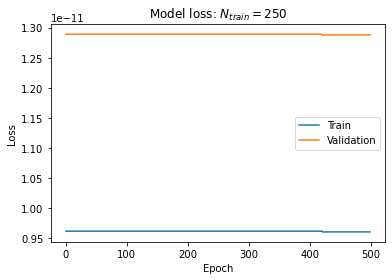

In [63]:
# look into training history
# Plot training & validation loss values
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss: $N_{train} = 250$')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

I valori della loss function sono maggiori per quanto riguarda il validation set rispetto al training set: questo è un comportamento tipico per gli errori di predizione di una rete neurale, in quanto il set di validazione contiene dati nuovi sui quali la rete non si è allenata in precedenza. Tuttavia la differenza tra i due errori è molto piccola: $\epsilon \propto 3,2 \cdot 10^{-12}$. Una $\epsilon$ elevata sarebbe indice di overfitting dei dati, ma essendo in questo caso molto piccola non rischiamo di incorrere in questo problema.

#### Variazione $\sigma$

Fissati ora gli iperparametri $N_{epoch} = 500$ e $N_{train} = 250$ (utilizzando minibatch di taglia $50$) si prova a far variare l'errore gaussiano $\sigma$.

In [2]:
model = tf.keras.Sequential(name='Sequential_model') 
model.add(Dense(1, input_shape=(1,)))  
model.compile(optimizer='sgd', loss='mse', metrics=['mse']) 

#### <span style="color:green">  $\sigma = 0.0$ </span>

In [5]:
#Genero i dati di training e di validation tra (-1, 1)
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 250)
x_valid = np.random.uniform(-1, 1, 25) #Valori di input del test set
x_valid.sort()

y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.0 # noise standard deviation

y_train = np.random.normal(m * x_train + b, sigma) #Label del training set
y_valid = np.random.normal(m * x_valid + b, sigma) #Label del test set

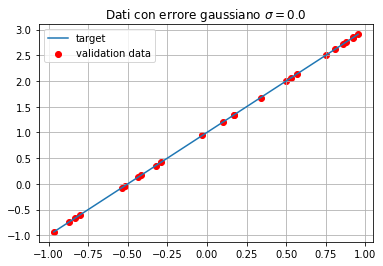

In [6]:
# plot validation and target dataset
plt.plot(x_valid, y_target, label='target')
plt.scatter(x_valid, y_valid, color='r', label='validation data')
plt.legend()
plt.title("Dati con errore gaussiano $\sigma = 0.0$")
plt.grid(True)
plt.show()

In [7]:
# fit the model using training dataset
# over 500 epochs of 32 batch size each
# report training progress against validation data
history_0 = model.fit(x=x_train, y=y_train, 
          batch_size=50, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [8]:
# return weights and biases
weights_0 = model.get_weights()
print("Valori dei pesi con errore 0.0: \n")

print("m = ", weights_0[0][0][0])
print("b = ", weights_0[1][0])

Valori dei pesi con errore 0.0: 

m =  1.9999928
b =  0.9999998


In [9]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=500, verbose=0)
loss_0 = score[0] 
acc_0 = score[1]

#### <span style="color:green">  $\sigma = 0.01$ </span>

In [10]:
#Genero i dati di training e di validation tra (-1, 1)
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 250)
x_valid = np.random.uniform(-1, 1, 25) #Valori di input del test set
x_valid.sort()

y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.01 # noise standard deviation

y_train = np.random.normal(m * x_train + b, sigma) #Label del training set
y_valid = np.random.normal(m * x_valid + b, sigma) #Label del test set

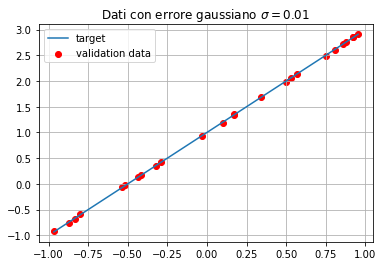

In [11]:
# plot validation and target dataset
plt.plot(x_valid, y_target, label='target')
plt.scatter(x_valid, y_valid, color='r', label='validation data')
plt.legend()
plt.title("Dati con errore gaussiano $\sigma = 0.01$")
plt.grid(True)
plt.show()

In [12]:
# fit the model using training dataset
# over 500 epochs of 32 batch size each
# report training progress against validation data
history_01 = model.fit(x=x_train, y=y_train, 
          batch_size=50, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [13]:
# return weights and biases
weights_01 = model.get_weights()
print("Valori dei pesi con errore 0.01: \n")

print("m = ", weights_01[0][0][0])
print("b = ", weights_01[1][0])

Valori dei pesi con errore 0.01: 

m =  2.0004373
b =  0.99892706


In [14]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=500, verbose=0)
loss_01 = score[0] 
acc_01 = score[1]

#### <span style="color:green">  $\sigma = 0.05$ </span>

In [15]:
#Genero i dati di training e di validation tra (-1, 1)
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 250)
x_valid = np.random.uniform(-1, 1, 25) #Valori di input del test set
x_valid.sort()

y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.05 # noise standard deviation

y_train = np.random.normal(m * x_train + b, sigma) #Label del training set
y_valid = np.random.normal(m * x_valid + b, sigma) #Label del test set

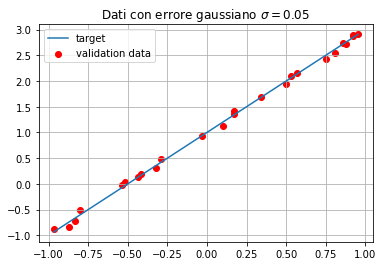

In [16]:
# plot validation and target dataset
plt.plot(x_valid, y_target, label='target')
plt.scatter(x_valid, y_valid, color='r', label='validation data')
plt.legend()
plt.title("Dati con errore gaussiano $\sigma = 0.05$")
plt.grid(True)
plt.show()

In [17]:
# fit the model using training dataset
# over 500 epochs of 32 batch size each
# report training progress against validation data
history_1 = model.fit(x=x_train, y=y_train, 
          batch_size=50, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [18]:
# return weights and biases
weights_1 = model.get_weights()
print("Valori dei pesi con errore 0.01: \n")

print("m = ", weights_1[0][0][0])
print("b = ", weights_1[1][0])

Valori dei pesi con errore 0.01: 

m =  2.002187
b =  0.99464154


In [19]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=500, verbose=0)
loss_1 = score[0] 
acc_1 = score[1]

#### <span style="color:green">  $\sigma = 0.1$ </span>

In [20]:
#Genero i dati di training e di validation tra (-1, 1)
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 250)
x_valid = np.random.uniform(-1, 1, 25) #Valori di input del test set
x_valid.sort()

y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.1 # noise standard deviation

y_train = np.random.normal(m * x_train + b, sigma) #Label del training set
y_valid = np.random.normal(m * x_valid + b, sigma) #Label del test set

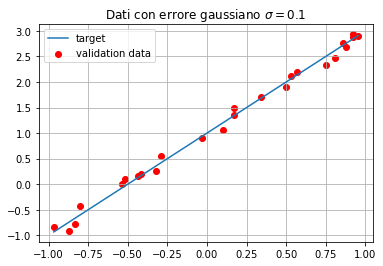

In [21]:
# plot validation and target dataset
plt.plot(x_valid, y_target, label='target')
plt.scatter(x_valid, y_valid, color='r', label='validation data')
plt.legend()
plt.title("Dati con errore gaussiano $\sigma = 0.1$")
plt.grid(True)
plt.show()

In [22]:
# fit the model using training dataset
# over 500 epochs of 32 batch size each
# report training progress against validation data
history_2 = model.fit(x=x_train, y=y_train, 
          batch_size=50, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [23]:
# return weights and biases
weights_2 = model.get_weights()
print("Valori dei pesi con errore 0.1: \n")

print("m = ", weights_2[0][0][0])
print("b = ", weights_2[1][0])

Valori dei pesi con errore 0.1: 

m =  2.0043745
b =  0.9893434


In [24]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=500, verbose=0)
loss_2 = score[0] 
acc_2 = score[1]

#### <span style="color:green">  $\sigma = 0.5$ </span>

In [25]:
#Genero i dati di training e di validation tra (-1, 1)
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 250)
x_valid = np.random.uniform(-1, 1, 25) #Valori di input del test set
x_valid.sort()

y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.5 # noise standard deviation

y_train = np.random.normal(m * x_train + b, sigma) #Label del training set
y_valid = np.random.normal(m * x_valid + b, sigma) #Label del test set

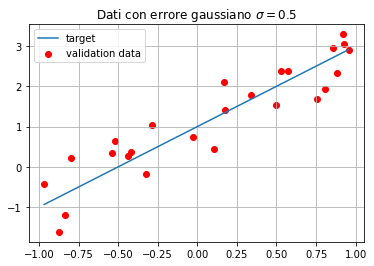

In [26]:
# plot validation and target dataset
plt.plot(x_valid, y_target, label='target')
plt.scatter(x_valid, y_valid, color='r', label='validation data')
plt.legend()
plt.title("Dati con errore gaussiano $\sigma = 0.5$")
plt.grid(True)
plt.show()

In [27]:
# fit the model using training dataset
# over 500 epochs of 32 batch size each
# report training progress against validation data
history_3 = model.fit(x=x_train, y=y_train, 
          batch_size=50, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [28]:
# return weights and biases
weights_3 = model.get_weights()
print("Valori dei pesi con errore 0.5: \n")

print("m = ", weights_3[0][0][0])
print("b = ", weights_3[1][0])

Valori dei pesi con errore 0.5: 

m =  2.0218194
b =  0.9464495


In [29]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=500, verbose=0)
loss_3 = score[0] 
acc_3 = score[1]

#### <span style="color:green">  $\sigma = 1.0$ </span>

In [30]:
#Genero i dati di training e di validation tra (-1, 1)
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 250)
x_valid = np.random.uniform(-1, 1, 25) #Valori di input del test set
x_valid.sort()

y_target = m * x_valid + b # ideal (target) linear function

sigma = 1.0 # noise standard deviation

y_train = np.random.normal(m * x_train + b, sigma) #Label del training set
y_valid = np.random.normal(m * x_valid + b, sigma) #Label del test set

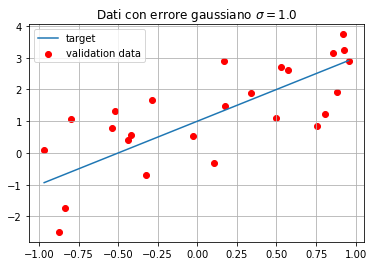

In [31]:
# plot validation and target dataset
plt.plot(x_valid, y_target, label='target')
plt.scatter(x_valid, y_valid, color='r', label='validation data')
plt.legend()
plt.title("Dati con errore gaussiano $\sigma = 1.0$")
plt.grid(True)
plt.show()

In [32]:
# fit the model using training dataset
# over 500 epochs of 32 batch size each
# report training progress against validation data
history_4 = model.fit(x=x_train, y=y_train, 
          batch_size=50, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [33]:
# return weights and biases
weights_4 = model.get_weights()
print("Valori dei pesi con errore 1.0: \n")

print("m = ", weights_4[0][0][0])
print("b = ", weights_4[1][0])

Valori dei pesi con errore 1.0: 

m =  2.0437853
b =  0.89282


In [34]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=500, verbose=0)
loss_4 = score[0] 
acc_4 = score[1]

All'aumentare degli errori il modello non riesce più a predirre in modo accurato i pesi. Possiamo confrontare i valori di loss ed accuracy nel caso $\sigma = 0.0$, $\sigma = 0.01$, $\sigma = 0.05$ e $\sigma = 0.1$: 

In [35]:
print("Loss ed accuracy con errore 0.0: \n")
print("Loss: ", loss_0)
print("Accuracy: ", acc_0)

Loss ed accuracy con errore 0.0: 

Loss:  2.1555916773774442e-11
Accuracy:  2.1555916773774442e-11


In [36]:
print("Loss ed accuracy con errore 0.01: \n")
print("Loss: ", loss_01)
print("Accuracy: ", acc_01)

Loss ed accuracy con errore 0.01: 

Loss:  0.00010837572335731238
Accuracy:  0.00010837572335731238


In [37]:
print("Loss ed accuracy con errore 0.05: \n")
print("Loss: ", loss_1)
print("Accuracy: ", acc_1)

Loss ed accuracy con errore 0.05: 

Loss:  0.0027093139942735434
Accuracy:  0.0027093139942735434


In [38]:
print("Loss ed accuracy con errore 0.1: \n")
print("Loss: ", loss_2)
print("Accuracy: ", acc_2)

Loss ed accuracy con errore 0.1: 

Loss:  0.010835569351911545
Accuracy:  0.010835569351911545


Si può notare come, all'aumentare dell'errore gaussiano $\sigma$, diminuisca l'accuratezza del modello. Per studiare un processo probabilistico affetto da errore mantenendo tuttavia una buona accuratezza ($L(x) \propto 10^{-4}$) si sceglie come valore dell'errore gaussiano $\sigma = 0.01$.

Possiamo valutare infine l'andamento della curva di predizione rispetto alla curva reale e l'andamento delle curve di loss function per training e validation set fissando i 3 iperparametri:
- $N_{epoch} = 500$
- $N_{train} = 250$
- $\sigma = 0.01$

In [39]:
#Genero i dati di training e di validation tra (-1, 1)
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 250)
x_valid = np.random.uniform(-1, 1, 25) #Valori di input del test set
x_valid.sort()

y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.01 # noise standard deviation

y_train = np.random.normal(m * x_train + b, sigma) #Label del training set
y_valid = np.random.normal(m * x_valid + b, sigma) #Label del test set

In [40]:
# fit the model using training dataset
# over 500 epochs of 32 batch size each
# report training progress against validation data
history_final = model.fit(x=x_train, y=y_train, 
          batch_size=50, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

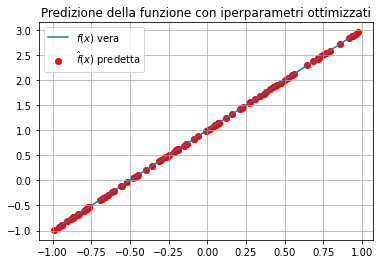

In [41]:
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r', label = "$\hat{f}(x)$ predetta")
plt.plot(x_valid, y_target, label = "$f(x)$ vera")
plt.title("Predizione della funzione con iperparametri ottimizzati")
plt.legend(loc="best")
plt.grid(True)
plt.show()

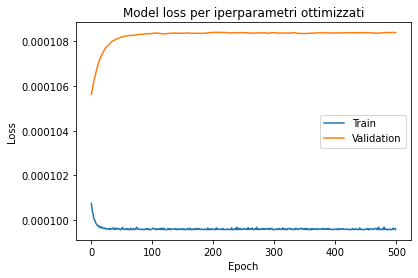

In [43]:
# look into training history
# Plot training & validation loss values
plt.plot(history_01.history['loss'])
plt.plot(history_01.history['val_loss'])
plt.title('Model loss per iperparametri ottimizzati')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

L'errore sul set di validazione è, come previsto, maggiore di quello sul test di training. La differenza tra gli errori dei due set è nell'ordine di $\epsilon \propto 8 \cdot 10^{-6}$: essendo molto piccola non vi è dunque un problema di overfitting dei dati.

### Esercizio 11.02

Scopo dell'esercizio è trovare una curva $\hat{f}(x)$ che riesca a fittare il polinomio di ordine tre:
$$
f(x)=4-3x-2x^2+3x^3
$$
per $x \in [-1,1]$.


Per esplorare le capacità predittive di una rete neurale si procede nel seguente modo:
- Si esplorano diverse opzioni di layer, fissando il numero di neuroni ($n = 4$ per input e hidden layers e $n=1$ per output layer)
- Trovati i layer che portano ad una loss minore, si provano a variare i neuroni di ciascun layer (escluso il layer di output per cui $n=1$ in tutti i modelli)
- Trovata infine profondità e spessore della **DNN** che fitti in modo accurato il polinomio di terzo grado, si prova ad esplorare varie opzioni per quanto riguarda la funzione d'attivazione, l'ottimizzatore, la funzione di loss e la metrica.

I vari modelli utilizzeranno gli stessi iperparametri:

- $N_{train} = 1000$, $N_{valid} = 100$
- $N_{epoch} = 500$
- $\sigma = 0.0$

Conoscendo la funzione delle true features $f(x)$, possiamo visualizzare l'andamento del nostro polinomio:

In [2]:
#Parametri target
a = 4
b = -3
c = -2
d = 3

In [3]:
# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 1000)
x_valid = np.random.uniform(-1, 1, 100)
x_valid.sort()
sigma = 0.0
y_train = np.random.normal(a + b * x_train + c * x_train**2 + d * x_train**3, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(a + b * x_valid + c * x_valid**2 + d * x_valid**3, sigma)

y_target = a + b * x_valid + c * x_valid**2 + d * x_valid**3 # ideal (target) linear function

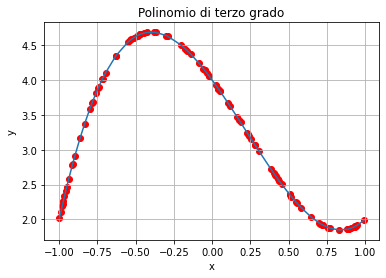

In [4]:
# plot training and target dataset
plt.plot(x_valid, y_target)
plt.scatter(x_valid, y_valid, color='r')
plt.title("Polinomio di terzo grado")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True); plt.show()

#### Variazione dei layers

In [5]:
model_1 = tf.keras.Sequential(name = 'Modello_sequenziale_2_layers')
model_1.add(Dense(4, input_shape=(1,), activation='relu'))
model_1.add(Dense(1, activation='relu'))


# compile the model choosing optimizer, loss and metrics objects
model_1.compile(optimizer='sgd', loss='mse', metrics=['mse'])
model_1.summary()

Model: "Modello_sequenziale_2_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 8         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [6]:
history_1 = model_1.fit(x=x_train, y=y_train, 
          batch_size=250, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [7]:
# evaluate model
score1 = model_1.evaluate(x_valid, y_valid, batch_size=250, verbose = 0)

print('Test loss modello 1:', score1[0])
print('Test accuracy modello 1:', score1[1])

Test loss modello 1: 0.0708903893828392
Test accuracy modello 1: 0.0708903893828392


In [8]:
model_2 = tf.keras.Sequential(name = 'Modello_sequenziale_3_layers')
model_2.add(Dense(4, input_shape=(1,), activation='relu'))
model_2.add(Dense(4, activation='relu'))
model_2.add(Dense(1, activation='relu'))


# compile the model choosing optimizer, loss and metrics objects
model_2.compile(optimizer='sgd', loss='mse', metrics=['mse'])
model_2.summary()

Model: "Modello_sequenziale_3_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4)                 8         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [9]:
history_2 = model_2.fit(x=x_train, y=y_train, 
          batch_size=250, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [10]:
# evaluate model
score2 = model_2.evaluate(x_valid, y_valid, batch_size=250, verbose = 0)

print('Test loss modello 2:', score2[0])
print('Test accuracy modello 2:', score2[1])

Test loss modello 2: 0.04752045124769211
Test accuracy modello 2: 0.04752045124769211


In [11]:
model_3 = tf.keras.Sequential(name = 'Modello_sequenziale_4_layers')
model_3.add(Dense(4, input_shape=(1,), activation='relu'))
model_3.add(Dense(4, activation='relu'))
model_3.add(Dense(4, activation='relu'))
model_3.add(Dense(1, activation='relu'))


# compile the model choosing optimizer, loss and metrics objects
model_3.compile(optimizer='sgd', loss='mse', metrics=['mse'])
model_3.summary()

Model: "Modello_sequenziale_4_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4)                 8         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________


In [12]:
history_3 = model_3.fit(x=x_train, y=y_train, 
          batch_size=250, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [13]:
# evaluate model
score3 = model_3.evaluate(x_valid, y_valid, batch_size=250, verbose = 0)

print('Test loss modello 3:', score3[0])
print('Test accuracy modello 3:', score3[1])

Test loss modello 3: 0.009482688270509243
Test accuracy modello 3: 0.009482688270509243


In [14]:
model_4 = tf.keras.Sequential(name = 'Modello_sequenziale_5_layers')
model_4.add(Dense(4, input_shape=(1,), activation='relu'))
model_4.add(Dense(4, activation='relu'))
model_4.add(Dense(4, activation='relu'))
model_4.add(Dense(4, activation='relu'))
model_4.add(Dense(1, activation='relu'))


# compile the model choosing optimizer, loss and metrics objects
model_4.compile(optimizer='sgd', loss='mse', metrics=['mse'])
model_4.summary()

Model: "Modello_sequenziale_5_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 4)                 8         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 5         
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________


In [15]:
history_4 = model_4.fit(x=x_train, y=y_train, 
          batch_size=250, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [16]:
# evaluate model
score4 = model_4.evaluate(x_valid, y_valid, batch_size=250, verbose = 0)

print('Test loss modello 4:', score4[0])
print('Test accuracy modello 4:', score4[1])

Test loss modello 4: 11.389304161071777
Test accuracy modello 4: 11.389304161071777


All'aumentare del numero di layers, si sono avute le seguenti variazioni nei fit della funzione polinomiale:

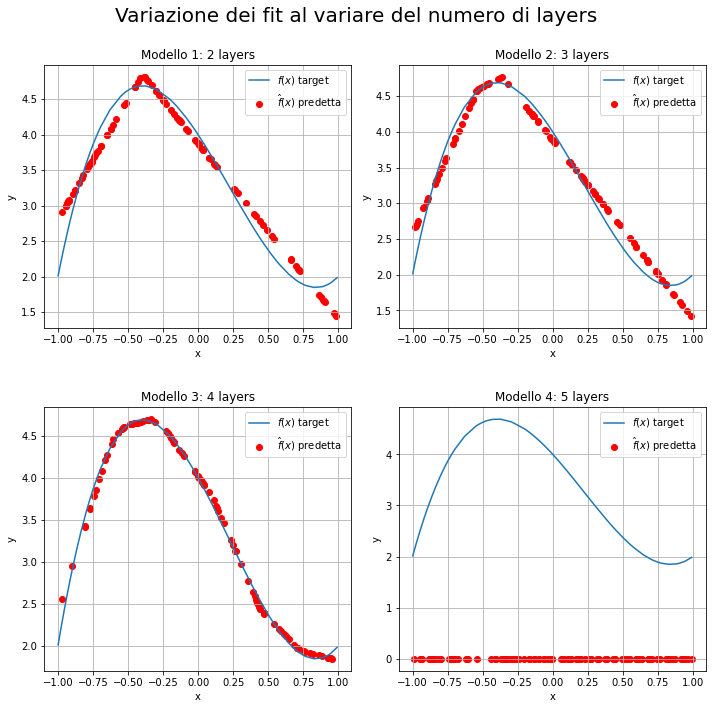

In [21]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model_1.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r', label = "$\hat{f}(x)$ predetta")
plt.plot(x_valid, y_target, label = "$f(x)$ target")
plt.title("Modello 1: 2 layers")
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.grid(True)

plt.subplot(2,2,2)
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model_2.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r', label = "$\hat{f}(x)$ predetta")
plt.plot(x_valid, y_target, label = "$f(x)$ target")
plt.title("Modello 2: 3 layers")
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.grid(True)

plt.subplot(2,2,3)
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model_3.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r', label = "$\hat{f}(x)$ predetta")
plt.plot(x_valid, y_target, label = "$f(x)$ target")
plt.title("Modello 3: 4 layers")
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.grid(True)

plt.subplot(2,2,4)
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model_4.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r', label = "$\hat{f}(x)$ predetta")
plt.plot(x_valid, y_target, label = "$f(x)$ target")
plt.title("Modello 4: 5 layers")
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.grid(True)

plt.suptitle("Variazione dei fit al variare del numero di layers", fontsize = 20)
plt.tight_layout()
plt.subplots_adjust(top=0.9,hspace=0.3)
plt.show()

Fino al modello $3$ vi è stata una progressiva diminuzione nella loss e nella accuracy, ed un progressivo miglioramento nella predizione. Passando da $4$ a $5$ layers nel quarto modello, invece, la rete non è stata più in grado di predirre la funzione target, e vi è dunque stata un'esplosione nei valori di loss ed accuracy. Poiché con il modello 3 si riesce ad ottenere la migliore accuratezza tra le opzioni valutate, fissiamo il numero di layers ottimale a $4$ e variamo il numero di neuroni per ogni strato, provando a diminuirlo o ad aumentarlo tenendo sempre come indicatori i valori di loss ed accuracy nelle varie prove.

#### Variazione numero di neuroni per layer

In [22]:
model_5 = tf.keras.Sequential(name = 'Modello_sequenziale_4_layers')
model_5.add(Dense(2, input_shape=(1,), activation='relu'))
model_5.add(Dense(4, activation='relu'))
model_5.add(Dense(4, activation='relu'))
model_5.add(Dense(1, activation='relu'))


# compile the model choosing optimizer, loss and metrics objects
model_5.compile(optimizer='sgd', loss='mse', metrics=['mse'])
model_5.summary()

Model: "Modello_sequenziale_4_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 2)                 4         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 5         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [23]:
history_5 = model_5.fit(x=x_train, y=y_train, 
          batch_size=250, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [24]:
# evaluate model
score5 = model_5.evaluate(x_valid, y_valid, batch_size=250, verbose = 0)

print('Test loss modello 1:', score5[0])
print('Test accuracy modello 1:', score5[1])

Test loss modello 1: 11.389304161071777
Test accuracy modello 1: 11.389304161071777


In [25]:
model_6 = tf.keras.Sequential(name = 'Modello_sequenziale_4_layers')
model_6.add(Dense(8, input_shape=(1,), activation='relu'))
model_6.add(Dense(4, activation='relu'))
model_6.add(Dense(4, activation='relu'))
model_6.add(Dense(1, activation='relu'))


# compile the model choosing optimizer, loss and metrics objects
model_6.compile(optimizer='sgd', loss='mse', metrics=['mse'])
model_6.summary()

Model: "Modello_sequenziale_4_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 5         
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________


In [26]:
history_6 = model_6.fit(x=x_train, y=y_train, 
          batch_size=250, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [27]:
# evaluate model
score6 = model_6.evaluate(x_valid, y_valid, batch_size=250, verbose = 0)

print('Test loss modello 2:', score6[0])
print('Test accuracy modello 2:', score6[1])

Test loss modello 2: 11.389304161071777
Test accuracy modello 2: 11.389304161071777


In [28]:
model_7 = tf.keras.Sequential(name = 'Modello_sequenziale_4_layers')
model_7.add(Dense(4, input_shape=(1,), activation='relu'))
model_7.add(Dense(2, activation='relu'))
model_7.add(Dense(4, activation='relu'))
model_7.add(Dense(1, activation='relu'))


# compile the model choosing optimizer, loss and metrics objects
model_7.compile(optimizer='sgd', loss='mse', metrics=['mse'])
model_7.summary()

Model: "Modello_sequenziale_4_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 5         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [29]:
history_7 = model_7.fit(x=x_train, y=y_train, 
          batch_size=250, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [30]:
# evaluate model
score7 = model_7.evaluate(x_valid, y_valid, batch_size=250, verbose = 0)

print('Test loss modello 3:', score7[0])
print('Test accuracy modello 3:', score7[1])

Test loss modello 3: 0.04612994194030762
Test accuracy modello 3: 0.04612994194030762


In [31]:
model_8 = tf.keras.Sequential(name = 'Modello_sequenziale_4_layers')
model_8.add(Dense(4, input_shape=(1,), activation='relu'))
model_8.add(Dense(8, activation='relu'))
model_8.add(Dense(4, activation='relu'))
model_8.add(Dense(1, activation='relu'))


# compile the model choosing optimizer, loss and metrics objects
model_8.compile(optimizer='sgd', loss='mse', metrics=['mse'])
model_8.summary()

Model: "Modello_sequenziale_4_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_27 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 5         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [32]:
history_8 = model_8.fit(x=x_train, y=y_train, 
          batch_size=250, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [33]:
# evaluate model
score8 = model_8.evaluate(x_valid, y_valid, batch_size=250, verbose = 0)

print('Test loss modello 4:', score8[0])
print('Test accuracy modello 4:', score8[1])

Test loss modello 4: 0.009536316618323326
Test accuracy modello 4: 0.009536316618323326


In [34]:
model_9 = tf.keras.Sequential(name = 'Modello_sequenziale_4_layers')
model_9.add(Dense(4, input_shape=(1,), activation='relu'))
model_9.add(Dense(16, activation='relu'))
model_9.add(Dense(4, activation='relu'))
model_9.add(Dense(1, activation='relu'))


# compile the model choosing optimizer, loss and metrics objects
model_9.compile(optimizer='sgd', loss='mse', metrics=['mse'])
model_9.summary()

Model: "Modello_sequenziale_4_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_31 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_32 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 5         
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [35]:
history_9 = model_9.fit(x=x_train, y=y_train, 
          batch_size=250, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [46]:
# evaluate model
score9 = model_9.evaluate(x_valid, y_valid, batch_size=250, verbose = 0)

print('Test loss modello 5:', score9[0])
print('Test accuracy modello 5:', score9[1])

Test loss modello 5: 0.006887616589665413
Test accuracy modello 5: 0.006887616589665413


In [37]:
model_10 = tf.keras.Sequential(name = 'Modello_sequenziale_4_layers')
model_10.add(Dense(4, input_shape=(1,), activation='relu'))
model_10.add(Dense(24, activation='relu'))
model_10.add(Dense(4, activation='relu'))
model_10.add(Dense(1, activation='relu'))


# compile the model choosing optimizer, loss and metrics objects
model_10.compile(optimizer='sgd', loss='mse', metrics=['mse'])
model_10.summary()

Model: "Modello_sequenziale_4_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_35 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_36 (Dense)             (None, 4)                 100       
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 5         
Total params: 233
Trainable params: 233
Non-trainable params: 0
_________________________________________________________________


In [38]:
history_10 = model_10.fit(x=x_train, y=y_train, 
          batch_size=250, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [47]:
# evaluate model
score10 = model_10.evaluate(x_valid, y_valid, batch_size=250, verbose = 0)

print('Test loss modello 6:', score10[0])
print('Test accuracy modello 6:', score10[1])

Test loss modello 6: 0.013907198794186115
Test accuracy modello 6: 0.013907198794186115


In [40]:
model_11 = tf.keras.Sequential(name = 'Modello_sequenziale_4_layers')
model_11.add(Dense(4, input_shape=(1,), activation='relu'))
model_11.add(Dense(16, activation='relu'))
model_11.add(Dense(2, activation='relu'))
model_11.add(Dense(1, activation='relu'))


# compile the model choosing optimizer, loss and metrics objects
model_11.compile(optimizer='sgd', loss='mse', metrics=['mse'])
model_11.summary()

Model: "Modello_sequenziale_4_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_39 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 34        
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 3         
Total params: 125
Trainable params: 125
Non-trainable params: 0
_________________________________________________________________


In [41]:
history_11 = model_11.fit(x=x_train, y=y_train, 
          batch_size=250, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [48]:
# evaluate model
score11 = model_11.evaluate(x_valid, y_valid, batch_size=250, verbose = 0)

print('Test loss modello 7:', score11[0])
print('Test accuracy modello 7:', score11[1])

Test loss modello 7: 11.389304161071777
Test accuracy modello 7: 11.389304161071777


In [43]:
model_12 = tf.keras.Sequential(name = 'Modello_sequenziale_4_layers')
model_12.add(Dense(4, input_shape=(1,), activation='relu'))
model_12.add(Dense(16, activation='relu'))
model_12.add(Dense(8, activation='relu'))
model_12.add(Dense(1, activation='relu'))


# compile the model choosing optimizer, loss and metrics objects
model_12.compile(optimizer='sgd', loss='mse', metrics=['mse'])
model_12.summary()

Model: "Modello_sequenziale_4_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_43 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_44 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 9         
Total params: 233
Trainable params: 233
Non-trainable params: 0
_________________________________________________________________


In [44]:
history_12 = model_12.fit(x=x_train, y=y_train, 
          batch_size=250, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [49]:
# evaluate model
score12 = model_12.evaluate(x_valid, y_valid, batch_size=250, verbose = 0)

print('Test loss modello 8:', score12[0])
print('Test accuracy modello 8:', score12[1])

Test loss modello 8: 11.389304161071777
Test accuracy modello 8: 11.389304161071777


Valutando i valori di loss ed accuracy al variare dei neuroni, scegliamo come modello finale per la nostra rete il **modello 4**, formato da:
- Input layer: $4$ neuroni
- Primo hidden layer: $16$ neuroni
- Secondo hidden layer: $4$ neuroni
- Output layer: $1$ neurone

Il valore della loss per questo modello è di

In [52]:
print("L(x) = ", score9[0])

L(x) =  0.006887616589665413


Il fit della predizione, rispetto alla funzione target, è il seguente:

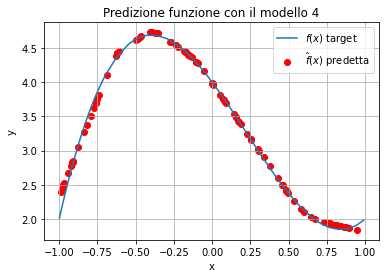

In [53]:
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model_9.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r', label = "$\hat{f}(x)$ predetta")
plt.plot(x_valid, y_target, label = "$f(x)$ target")
plt.title("Predizione funzione con il modello 4")
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.grid(True)

Infine possiamo provare a variare la funzione d'attivazione, l'ottimizzatore e la loss function per vedere se si ottiene qualche miglioramento nella predizione.

Essendo il nostro problema un problema di regressione il cui output è illimitato, possiamo provare ad utilizzare come funzioni d'attivazione dell'output layer funzioni con dominio aperto:
- Funzione **lineare** $f(x) = x$,
- Funzione **softplus** $f(x) = \ln(1 + e^{x})$
- Funzione **elu** $f(x) = x \quad per \quad x > 0$, $f(x) = \alpha(e^x - 1) \quad per \quad x < 0$ con $\alpha = 1.0$
- Funzione **selu** $f(x) = \gamma f_{elu}(x, \alpha)$

Si continua ad usare la funzione **ReLU** per input ed hidden layers. 
Si proverà inoltre ad utilizzare come ottimizzatore un **adagrad** al posto dell'**sgd**, e come loss function una **mean absolute error** ed una **logcosh**

#### Variazione funzione d'attivazione

In [54]:
model_13 = tf.keras.Sequential(name = 'Funzione_attivazione_lineare_output_layer')
model_13.add(Dense(4, input_shape=(1,), activation='relu'))
model_13.add(Dense(16, activation='relu'))
model_13.add(Dense(4, activation='relu'))
model_13.add(Dense(1, activation='linear'))


# compile the model choosing optimizer, loss and metrics objects
model_13.compile(optimizer='sgd', loss='mse', metrics=['mse'])
model_13.summary()

Model: "Funzione_attivazione_lineare_output_layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_47 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_48 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 5         
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [55]:
history_13 = model_13.fit(x=x_train, y=y_train, 
          batch_size=250, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [56]:
# evaluate model
score13 = model_13.evaluate(x_valid, y_valid, batch_size=250, verbose = 0)

print('Test loss con funzione attivazione lineare:', score13[0])
print('Test accuracy con funzione attivazione lineare:', score13[1])

Test loss con funzione attivazione lineare: 0.07525638490915298
Test accuracy con funzione attivazione lineare: 0.07525638490915298


In [58]:
model_14 = tf.keras.Sequential(name = 'Funzione_attivazione_softplus_output_layer')
model_14.add(Dense(4, input_shape=(1,), activation='relu'))
model_14.add(Dense(16, activation='relu'))
model_14.add(Dense(4, activation='relu'))
model_14.add(Dense(1, activation='softplus'))


# compile the model choosing optimizer, loss and metrics objects
model_14.compile(optimizer='sgd', loss='mse', metrics=['mse'])
model_14.summary()

Model: "Funzione_attivazione_softplus_output_layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_55 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_56 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 5         
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [59]:
history_14 = model_14.fit(x=x_train, y=y_train, 
          batch_size=250, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [60]:
# evaluate model
score14 = model_14.evaluate(x_valid, y_valid, batch_size=250, verbose = 0)

print('Test loss con funzione attivazione softplus:', score14[0])
print('Test accuracy con funzione attivazione softplus:', score14[1])

Test loss con funzione attivazione softplus: 0.007261374499648809
Test accuracy con funzione attivazione softplus: 0.007261374499648809


In [61]:
model_15 = tf.keras.Sequential(name = 'Funzione_attivazione_selu_output_layer')
model_15.add(Dense(4, input_shape=(1,), activation='relu'))
model_15.add(Dense(16, activation='relu'))
model_15.add(Dense(4, activation='relu'))
model_15.add(Dense(1, activation='selu'))


# compile the model choosing optimizer, loss and metrics objects
model_15.compile(optimizer='sgd', loss='mse', metrics=['mse'])
model_15.summary()

Model: "Funzione_attivazione_selu_output_layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_59 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_60 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 5         
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [62]:
history_15 = model_15.fit(x=x_train, y=y_train, 
          batch_size=250, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [63]:
# evaluate model
score15 = model_15.evaluate(x_valid, y_valid, batch_size=250, verbose = 0)

print('Test loss con funzione attivazione selu:', score15[0])
print('Test accuracy con funzione attivazione selu:', score15[1])

Test loss con funzione attivazione selu: 0.06415902078151703
Test accuracy con funzione attivazione selu: 0.06415902078151703


In [64]:
model_16 = tf.keras.Sequential(name = 'Funzione_attivazione_elu_output_layer')
model_16.add(Dense(4, input_shape=(1,), activation='relu'))
model_16.add(Dense(16, activation='relu'))
model_16.add(Dense(4, activation='relu'))
model_16.add(Dense(1, activation='elu'))


# compile the model choosing optimizer, loss and metrics objects
model_16.compile(optimizer='sgd', loss='mse', metrics=['mse'])
model_16.summary()

Model: "Funzione_attivazione_elu_output_layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_63 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_64 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 5         
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [65]:
history_16 = model_16.fit(x=x_train, y=y_train, 
          batch_size=250, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [66]:
# evaluate model
score16 = model_16.evaluate(x_valid, y_valid, batch_size=250, verbose = 0)

print('Test loss con funzione attivazione elu:', score16[0])
print('Test accuracy con funzione attivazione elu:', score16[1])

Test loss con funzione attivazione elu: 0.009005733765661716
Test accuracy con funzione attivazione elu: 0.009005733765661716


#### Variazione ottimizzatore

In [67]:
model_17 = tf.keras.Sequential(name = 'Ottimizzatore_adagrad')
model_17.add(Dense(4, input_shape=(1,), activation='relu'))
model_17.add(Dense(16, activation='relu'))
model_17.add(Dense(4, activation='relu'))
model_17.add(Dense(1, activation='relu'))


# compile the model choosing optimizer, loss and metrics objects
model_17.compile(optimizer='adagrad', loss='mse', metrics=['mse'])
model_17.summary()

Model: "Ottimizzatore_adagrad"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_67 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_68 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 5         
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [68]:
history_17 = model_17.fit(x=x_train, y=y_train, 
          batch_size=250, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [69]:
# evaluate model
score17 = model_17.evaluate(x_valid, y_valid, batch_size=250, verbose = 0)

print('Test loss con ottimizzatore adagrad:', score17[0])
print('Test accuracy con ottimizzatore adagrad:', score17[1])

Test loss con ottimizzatore adagrad: 5.914315700531006
Test accuracy con ottimizzatore adagrad: 5.914315700531006


#### Variazione loss function (e metrica)

In [70]:
model_18 = tf.keras.Sequential(name = 'Loss_mae')
model_18.add(Dense(4, input_shape=(1,), activation='relu'))
model_18.add(Dense(16, activation='relu'))
model_18.add(Dense(4, activation='relu'))
model_18.add(Dense(1, activation='relu'))


# compile the model choosing optimizer, loss and metrics objects
model_18.compile(optimizer='sgd', loss='mae', metrics=['mae'])
model_18.summary()

Model: "Loss_mae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_71 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_72 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 5         
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [71]:
history_18 = model_18.fit(x=x_train, y=y_train, 
          batch_size=250, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [72]:
# evaluate model
score18 = model_18.evaluate(x_valid, y_valid, batch_size=250, verbose = 0)

print('Test loss con mean absolute error:', score18[0])
print('Test accuracy con mean absolute error:', score18[1])

Test loss con mean absolute error: 3.2225160598754883
Test accuracy con mean absolute error: 3.2225160598754883


In [73]:
model_19 = tf.keras.Sequential(name = 'Loss_logcosh')
model_19.add(Dense(4, input_shape=(1,), activation='relu'))
model_19.add(Dense(16, activation='relu'))
model_19.add(Dense(4, activation='relu'))
model_19.add(Dense(1, activation='relu'))


# compile the model choosing optimizer, loss and metrics objects
model_19.compile(optimizer='sgd', loss='logcosh', metrics=['logcosh'])
model_19.summary()

Model: "Loss_logcosh"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_75 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_76 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 5         
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [74]:
history_19 = model_19.fit(x=x_train, y=y_train, 
          batch_size=250, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [75]:
# evaluate model
score19 = model_19.evaluate(x_valid, y_valid, batch_size=250, verbose = 0)

print('Test loss con logcosh:', score19[0])
print('Test accuracy con logcosh:', score19[1])

Test loss con logcosh: 2.535947322845459
Test accuracy con logcosh: 2.535947322845459


Dunque la scelta migliore è quella di utilizzare una **ReLU** come funzione d'attivazione dell'output layer, un'ottimizzatore **stochastic gradient descent** e una loss function **mean squared error**. La predizione migliore che la rete riesce a fare per fittare il polinomio di terzo grado resta dunque quella fatta in precedenza:

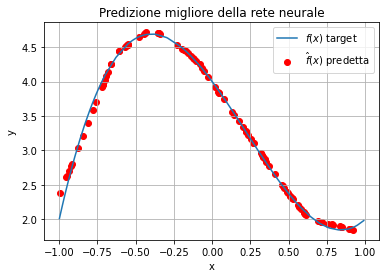

In [76]:
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model_9.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r', label = "$\hat{f}(x)$ predetta")
plt.plot(x_valid, y_target, label = "$f(x)$ target")
plt.title("Predizione migliore della rete neurale")
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.grid(True)

In [8]:
# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 1000)
x_valid = np.random.uniform(1, 3, 100)
x_valid.sort()
sigma = 0.0
y_train = np.random.normal(a + b * x_train + c * x_train**2 + d * x_train**3, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(a + b * x_valid + c * x_valid**2 + d * x_valid**3, sigma)

y_target = a + b * x_valid + c * x_valid**2 + d * x_valid**3 # ideal (target) linear function

In [15]:
model_a = tf.keras.Sequential(name = 'Modello_sequenziale_4_layers')
model_a.add(Dense(4, input_shape=(1,), activation='relu'))
model_a.add(Dense(16, activation='relu'))
model_a.add(Dense(4, activation='relu'))
model_a.add(Dense(1, activation='relu'))


# compile the model choosing optimizer, loss and metrics objects
model_a.compile(optimizer='sgd', loss='mse', metrics=['mse'])

In [16]:
history_a = model_a.fit(x=x_train, y=y_train, 
          batch_size=250, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

Tuttavia, nonostante si sia fatta una buona predizione per la funzione nell'intervallo $[-1, 1]$, possiamo notare come, scegliendo valori di predizione al di fuori dell'intervallo di valori su cui è stata allenata la rete, essa non riesca più a predirre l'andamento della funzione:

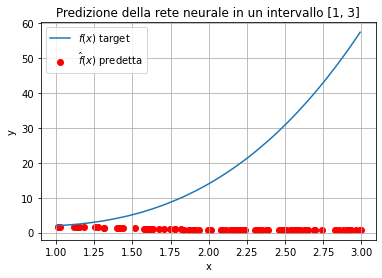

In [19]:
x_predicted = np.random.uniform(1, 3, 100)
y_predicted = model_a.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r', label = "$\hat{f}(x)$ predetta")
plt.plot(x_valid, y_target, label = "$f(x)$ target")
plt.title("Predizione della rete neurale in un intervallo [1, 3]")
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.grid(True)

### Esercizio 11.03

In [6]:
np.random.seed(0)
x_train = np.zeros((10000, 2))
x_valid = np.zeros((2500, 2))

x_train[:, 0] = np.random.uniform(-3/2, 3/2, 10000)
x_train[:, 1] = np.random.uniform(-3/2, 3/2, 10000)
x_valid[:, 0] = np.random.uniform(-3/2, 3/2, 2500) #Valori di input del test set
x_valid[:, 1] = np.random.uniform(-3/2, 3/2, 2500)
x_valid.sort()

y_train = np.sin(x_train[:, 0]**2 + x_train[:, 1]**2) #Label del training set
y_valid = np.sin(x_valid[:, 0]**2 + x_valid[:, 1]**2) #Label del test set

In [7]:
x_target = np.zeros((10000, 2))
x_target[:, 0] = np.random.uniform(-3/2, 3/2, 10000)
x_target[:, 1] = np.random.uniform(-3/2, 3/2, 10000)
y_target = np.sin(x_target[:, 0]**2 + x_target[:, 1]**2)

Scopo dell'esercizio è riuscire a fittare una funzione trigonometrica bidimensionale:
$$f(x,y) = \sin(x^2+y^2)$$

nel range di valori $x \in [-3/2,3/2]$ e $y \in [-3/2,3/2]$.

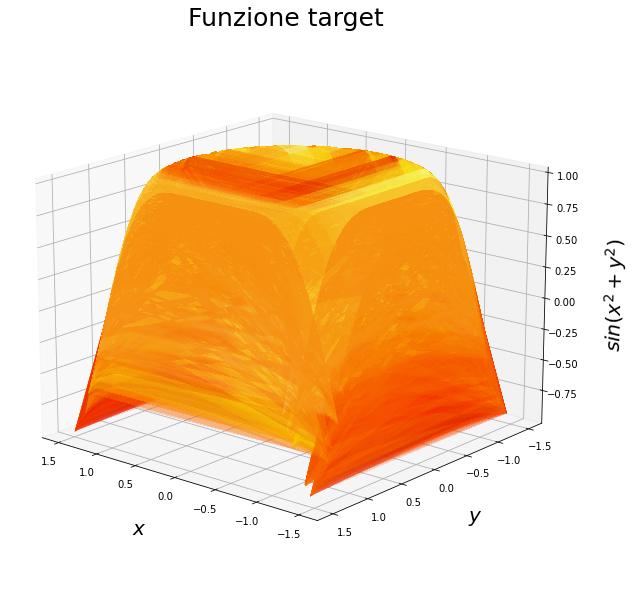

In [40]:
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Funzione target', fontsize=25)
X, Y = np.meshgrid(x_target[:, 0], x_target[:, 1])
f = np.array([np.sin(x**2+y**2) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = f.reshape(X.shape)
ax.set_xlabel('$x$', fontsize=20, labelpad=20)
ax.set_ylabel('$y$', fontsize=20, labelpad=20)
ax.set_zlabel('$sin(x^2+y^2)$', fontsize=20, labelpad=20)
surf = ax.plot_surface(X, Y, Z, cmap= 'hot', alpha = 0.1, antialiased=False)
ax.view_init(17, 130)
plt.show()

In [5]:
#DNN Architecture
model = tf.keras.Sequential(name='Sequential_model') 
model.add(Dense(256, input_shape=(2,), activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1,activation = 'tanh'))  

model.compile(optimizer='sgd', loss='mse', metrics=['mse']) 

Il modello utilizzato per questo problema consta di $5$ layers, con un numero di neuroni decrescenti per ogni layer:
- $256$ neuroni per l'input layer
- $128$ neuroni per il primo hidden layer
- $64$ neuroni per il secondo hidden layer
- $32$ neuroni per il terzo hidden layer
- $1$ neurone per l'output layer

Come funzioni d'attivazione viene utilizzata la **ReLU** per input ed hidden layers, mentre per l'output layer si sceglie di utilizzare una *tangente iperbolica* $f(x) = tanh(x)$. Essa è una funzione che presenta un valore massimo di plateau sia per valori positivi che negativi, ed è particolarmente adeguata per problemi che, come una funzione trigonometrica, hanno output limitato.

Come ottimizzatore si utilizza uno **stochastic gradient descent** e per funzione di loss e metrica una **mean squared error**.

In [37]:
model.summary()

Model: "Sequential_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               768       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 44,033
Trainable params: 44,033
Non-trainable params: 0
_________________________________________________________________


Gli iperparametri utilizzati sono:
- $N_{train} = 10^4$ 
- $N_{valid} = 2 \cdot 10^3$
- $N_{epoch} = 500$
- $batchsize = 2500$

Dopo $500$ epoche, si trovano i seguenti valori di loss ed accuracy:

In [10]:
history = model.fit(x=x_train, y=y_train, 
          batch_size=2500, epochs=500,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [11]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=250, verbose = 0)

print('Test loss modello:', score[0])
print('Test accuracy modello:', score[1])

Test loss modello: 0.019141195341944695
Test accuracy modello: 0.019141195341944695


Possiamo svolgere la predizione della funzione e visionarla sia in $3D$ sia lungo i piani $x-z$ ed $y-z$

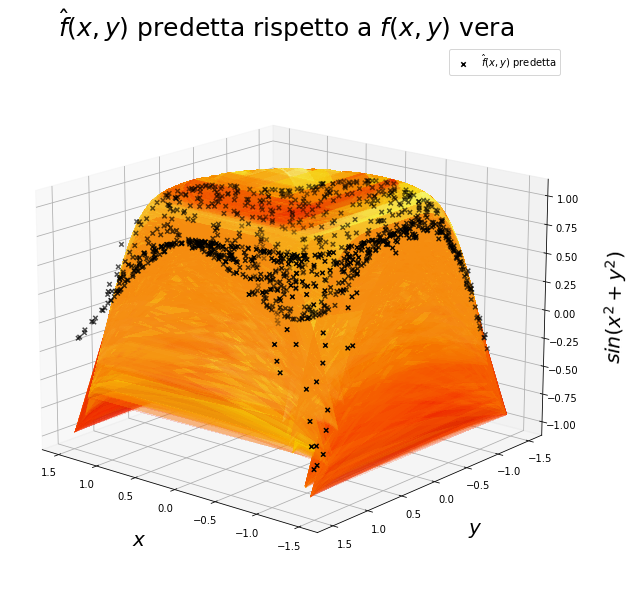

In [36]:
x_predicted = np.zeros((1000, 2))
x_predicted[:, 0] = np.random.uniform(-3/2, 3/2,1000)
x_predicted[:, 1] = np.random.uniform(-3/2, 3/2, 1000)
y_predicted = model.predict(x_predicted)


fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('$\hat{f}(x,y)$ predetta rispetto a $f(x,y)$ vera', fontsize=25)
X, Y = np.meshgrid(x_target[:, 0], x_target[:, 1])
f = np.array([np.sin(x**2+y**2) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = f.reshape(X.shape)
ax.set_xlabel('$x$', fontsize=20, labelpad=20)
ax.set_ylabel('$y$', fontsize=20, labelpad=20)
ax.set_zlabel('$sin(x^2+y^2)$', fontsize=20, labelpad=20)
surf = ax.plot_surface(X, Y, Z, cmap= 'hot', alpha = 0.1, antialiased=False)
ax.scatter3D(x_predicted[:, 0], x_predicted[:, 1], y_predicted, color='k', marker="x",
             label='$\hat{f}(x,y)$ predetta')
ax.view_init(17, 130)
plt.legend(loc='best')
plt.show()

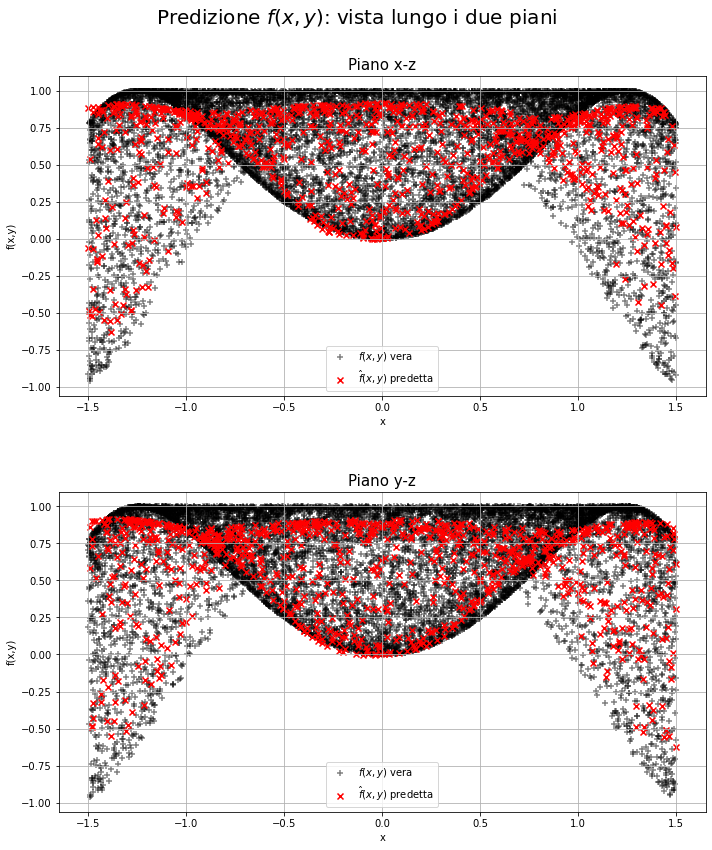

In [27]:
plt.figure(figsize = (10,12))
plt.subplot(2,1,1)
plt.scatter(x_target[:,0],y_target, color = 'k', marker = '+', alpha = 0.5, label = "$f(x,y)$ vera")
plt.scatter(x_predicted[:,0], y_predicted,color='r', marker = 'x', label = "$\hat{f}(x,y)$ predetta")
plt.xlabel("x")
plt.ylabel("f(x,y)")
plt.title("Piano x-z", fontsize = 15)
plt.legend(loc = 'best')
plt.grid(True)

plt.subplot(2,1,2)
plt.scatter(x_target[:,1],y_target, color = 'k', marker = '+', alpha = 0.5, label = "$f(x,y)$ vera")
plt.scatter(x_predicted[:,1], y_predicted,color='r', marker = 'x', label = "$\hat{f}(x,y)$ predetta")
plt.xlabel("x")
plt.ylabel("f(x,y)")
plt.title("Piano y-z", fontsize = 15)
plt.legend(loc = 'best')
plt.grid(True)

plt.suptitle("Predizione $f(x,y)$: vista lungo i due piani", fontsize = 20)
plt.tight_layout()
plt.subplots_adjust(top=0.9,hspace=0.3)
plt.show()

Dopo $500$ epoche, dunque, abbiamo ottenuto una loss $L(x) \propto 10^{-3}$. Plottando l'andamento della loss per i set di training e di validazione, tuttavia, si può notare che essa continua ad avere un andamento decrescente lungo le $500$ epoche.

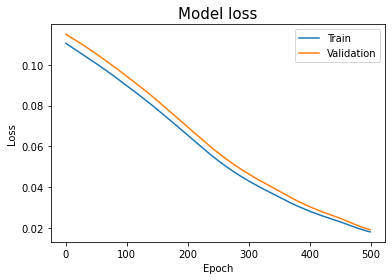

In [39]:
# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss', fontsize = 15)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

Questo comportamento della loss function fa supporre che, per il modello scelto, $500$ epoche non siano sufficienti e che sia possibile raggiungere un'accuratezza maggiore facendo una simulazione su un numero di epoche maggiori.

Viene svolta allora una simulazione con lo stesso modello descritto in precedenza, ma scegliendo $N_{epoch} = 10^3$. Si ottengono i seguenti valori di loss ed accuracy:

In [41]:
history_2 = model.fit(x=x_train, y=y_train, 
          batch_size=2500, epochs=1000,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), verbose = 0)

In [42]:
# evaluate model
score2 = model.evaluate(x_valid, y_valid, batch_size=250, verbose = 0)

print('Test loss modello 1000 epoche:', score2[0])
print('Test accuracy modello 1000 epoche:', score2[1])

Test loss modello 1000 epoche: 0.0016824344638735056
Test accuracy modello 1000 epoche: 0.0016824344638735056


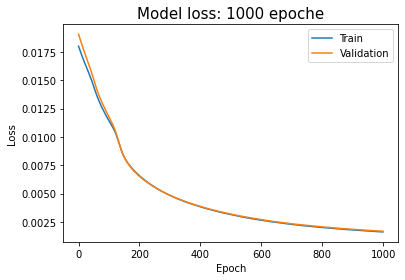

In [45]:
# look into training history
# Plot training & validation loss values
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss: 1000 epoche', fontsize = 15)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

Aumentando il numero di epoche a $10^3$, otteniamo una loss function $L(x) \propto 10^{-4}$.

Si riesce ad ottenere dunque una predizione migliore della funzione:

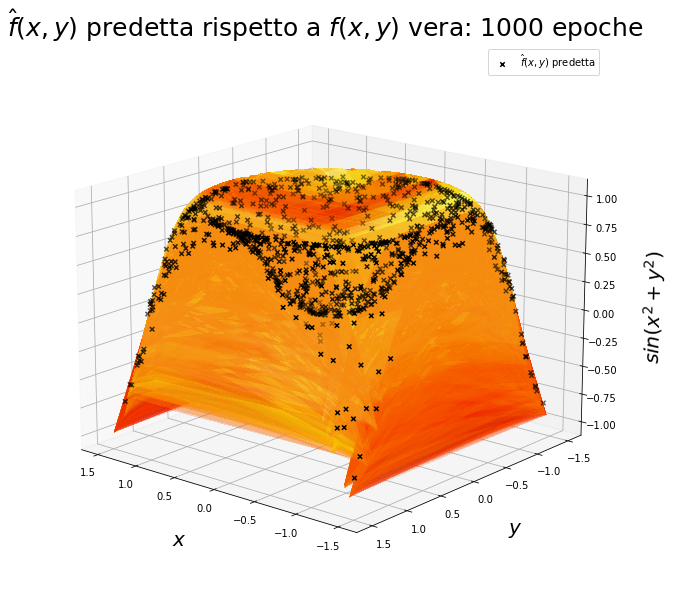

In [43]:
x_predicted = np.zeros((1000, 2))
x_predicted[:, 0] = np.random.uniform(-3/2, 3/2,1000)
x_predicted[:, 1] = np.random.uniform(-3/2, 3/2, 1000)
y_predicted = model.predict(x_predicted)


fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('$\hat{f}(x,y)$ predetta rispetto a $f(x,y)$ vera: 1000 epoche', fontsize=25)
X, Y = np.meshgrid(x_target[:, 0], x_target[:, 1])
f = np.array([np.sin(x**2+y**2) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = f.reshape(X.shape)
ax.set_xlabel('$x$', fontsize=20, labelpad=20)
ax.set_ylabel('$y$', fontsize=20, labelpad=20)
ax.set_zlabel('$sin(x^2+y^2)$', fontsize=20, labelpad=20)
surf = ax.plot_surface(X, Y, Z, cmap= 'hot', alpha = 0.1, antialiased=False)
ax.scatter3D(x_predicted[:, 0], x_predicted[:, 1], y_predicted, color='k', marker="x",
             label='$\hat{f}(x,y)$ predetta')
ax.view_init(17, 130)
plt.legend(loc='best')
plt.show()

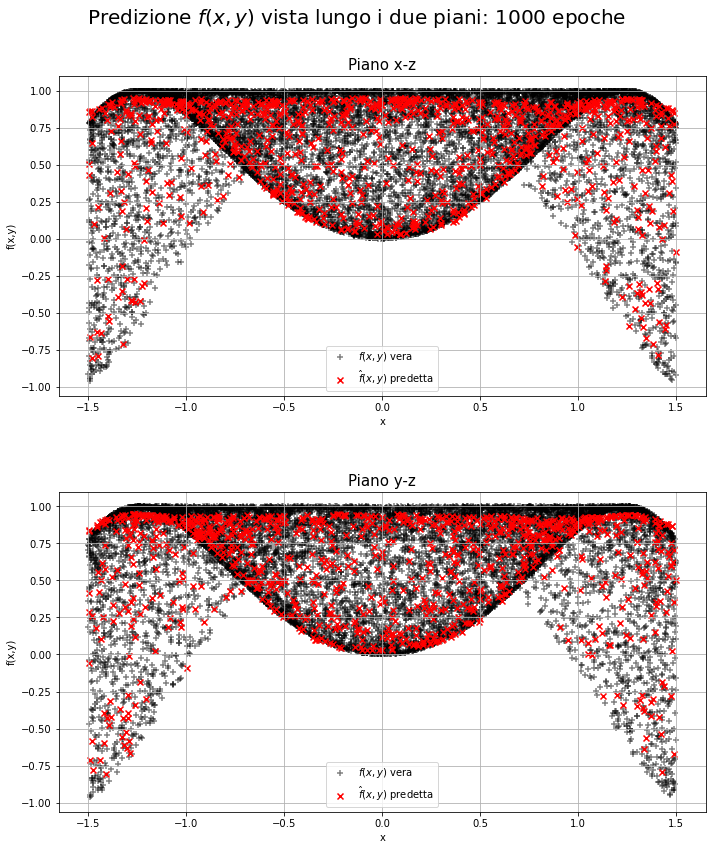

In [44]:
plt.figure(figsize = (10,12))
plt.subplot(2,1,1)
plt.scatter(x_target[:,0],y_target, color = 'k', marker = '+', alpha = 0.5, label = "$f(x,y)$ vera")
plt.scatter(x_predicted[:,0], y_predicted,color='r', marker = 'x', label = "$\hat{f}(x,y)$ predetta")
plt.xlabel("x")
plt.ylabel("f(x,y)")
plt.title("Piano x-z", fontsize = 15)
plt.legend(loc = 'best')
plt.grid(True)

plt.subplot(2,1,2)
plt.scatter(x_target[:,1],y_target, color = 'k', marker = '+', alpha = 0.5, label = "$f(x,y)$ vera")
plt.scatter(x_predicted[:,1], y_predicted,color='r', marker = 'x', label = "$\hat{f}(x,y)$ predetta")
plt.xlabel("x")
plt.ylabel("f(x,y)")
plt.title("Piano y-z", fontsize = 15)
plt.legend(loc = 'best')
plt.grid(True)

plt.suptitle("Predizione $f(x,y)$ vista lungo i due piani: 1000 epoche", fontsize = 20)
plt.tight_layout()
plt.subplots_adjust(top=0.9,hspace=0.3)
plt.show()